In [1]:
# py27 compatability
from __future__ import print_function
from __future__ import division
# load packages
import numpy as np                                          # advanced array functions
import pandas as pd                                         # DataFrames
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt                             # plotting
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
# configure matplotlib
%matplotlib inline
import seaborn as sns                                       # statistics/ plotting
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm                                       # progress bar
import sspals
from mc_positronium import *

## Ps conversion

In [2]:
# simulate Ps converter
num=1e5
T = 800
sim_bk = Ps_converter(num, T=T)

## Laser Interaction

In [3]:
laser = Laser(wavelength=243.0e-9, trigger=1.5e-8, height=0.008)
lyman_a = Spectroscopy(lambda_0=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
# excitation threshold
ol_threshold = 0.001

## delay scan

In [4]:
# SSPALS spectrum
laser_off = sim_bk['time of death']

# convolve
dt = 1e-9
bins = np.arange(-5e-8, 8e-7, dt)
pwo = detector(np.arange(-1e-8, 2e-7, dt), 1e-8)
lt_off = np.histogram(laser_off.values, bins=bins, density=False)[0]
spectra_off = np.convolve(lt_off, pwo)

#delay
spectra = []
trig_vals = np.arange(0, 2.5e-7, 1e-8)
for trig in tqdm(trig_vals, desc='delay', leave=False):
    sim = Ps_converter(num, T=T)
    lz = Laser(wavelength=243.0e-9, trigger=trig, height=0.008, distance=0.002)
    laser_on = lyman_a.photoionize(sim, lz, ol_threshold)['time of death']
    lt_on = np.histogram(laser_on.values, bins=bins, density=False)[0]
    spectra.append(np.convolve(lt_on, pwo))

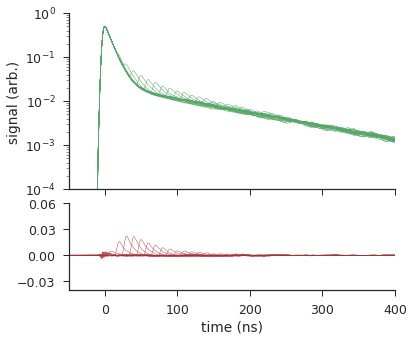

In [5]:
# plot setup
fig, ax = plt.subplots(figsize=(6,5))

# background subtraction subplot
divider = make_axes_locatable(ax)
axx = divider.append_axes("bottom", size=1.2, pad=0.2, sharex=ax)

# background
x_vals = np.arange(len(spectra_off)) * dt
rescale_off = 0.5*spectra_off / max(spectra_off)
#ax.plot(x_vals * 1e9 - 62, rescale_off, lw=1, zorder=100, label='background')

# signal
for spectra_on in spectra:
    rescale_on =  0.5*spectra_on / max(spectra_off)
    ax.plot(x_vals * 1e9 -62, rescale_on, lw=0.5, c=sns.color_palette()[1])
    axx.plot(x_vals * 1e9 -62, rescale_on - rescale_off, lw=0.5, c=sns.color_palette()[2])

#format
#ax.legend()
#axx.legend()
ax.set_yscale('log')
ax.set_ylabel("signal (arb.)")
axx.set_xlabel("time (ns)")
ax.set_ylim(1e-4, 1)
ax.set_xlim(-50, 400)
sns.despine()
plt.setp(ax.get_xticklabels(), visible=False)
axx.set_ylim([-0.04, 0.06])
axx.set_yticks([-0.03, 0, 0.03, 0.06])
axx.axhline(0, color='k', lw=0.5, alpha=0.5)

#output
plt.tight_layout()
plt.savefig("../images/mc_leptof.pdf", dpi=200, bbox_inches='tight')
plt.show()

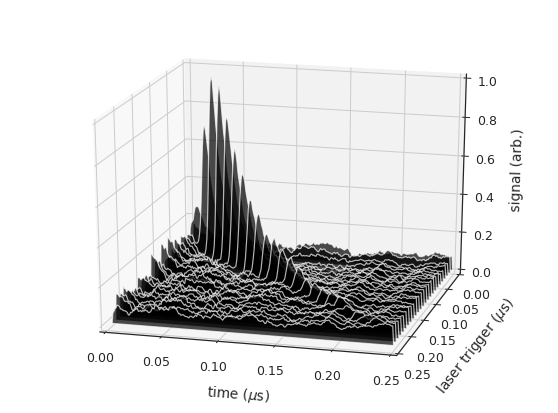

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np


fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

m1 = ((x_vals * 1e9 -62)*1e-3) > 0 
m2 = ((x_vals * 1e9 -62)*1e-3) < 0.25
mask = m1 & m2
xs = ((x_vals * 1e9 -62)*1e-3)[mask]
verts = []
yoffset = 0.08
for spectra_on in spectra:
    rescale_on =  0.5*spectra_on / max(spectra_off)
    ys = (rescale_on - rescale_off)[mask]/0.025
    ys[0], ys[-1] = -yoffset, -yoffset
    verts.append(list(zip(xs, ys+yoffset)))

poly = PolyCollection(verts, facecolors='k', edgecolors='w', linewidths=1.2)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=trig_vals*1e6, zdir='y')
ax.set_xlabel('\n time ($\mu$s)', linespacing=3)
ax.set_xlim3d(0, 0.25)
ax.set_ylabel('\n laser trigger ($\mu$s)', linespacing=3)
ax.set_ylim3d(0.25, 0)
ax.set_zlabel('\n signal (arb.)', linespacing=3)
ax.set_zlim3d(0, 1)
ax.view_init(elev=20., azim=-75)

# output
plt.tight_layout()
plt.savefig("../images/mc_leptof_3d.pdf", dpi=200, bbox_inches='tight')
plt.show()